# About

This is the `hotdog not hotdog` model from the famous Silicon Valley show.

This is a binary classification problem in which we have 1 category for hotdogs and 1 category for everything else.

In [1]:
import fastbook
fastbook.setup_book()

In [2]:
import os
try:
    os.chdir("SeeFood_app/")
except:
    pass

# Prep the data

In [5]:
bing_search_key = os.environ.get("AZURE_SEARCH_KEY", "6273c24c4aba4abca4ac8420b973d69f")

In [3]:
path = fastbook.Path("images")
if not path.exists():
    path.mkdir()

In [7]:
def search_images(term):
    """ Given a term, searches the images and returns the URLs of the images """
    results = fastbook.search_images_bing(bing_search_key, term)
    return results.attrgot("contentUrl")

In [8]:
def populate_directory(dir, urls):
    """ Given the URLs of the images, downloads them and stores them in the given directory """
    dest = (path/dir)
    dest.mkdir(exist_ok=True)
    fastbook.download_images(dest, urls=urls)

---

## Populate images

In [9]:
# Populate hotdog images
hotdog_image_urls = search_images("hotdogs")
populate_directory("hotdogs", hotdog_image_urls)

It's important to note here that the path in which we save the `not-hotdog` images is going to define the classes our model can predict.

In this case, I will store all the `non-hotdog` images in teh `non_hotdog` directory so that the `get_parent()` function in my `Datablock` is going to use the parent directory of the image as a category.

In [10]:
# Populate non-hotdog images
food_types = ["pizza", "pasta", "hamburger"]
for food in food_types:
    non_hotdog_image_urls = search_images(food)
    populate_directory("not_hotdog", non_hotdog_image_urls)

---

## Clean images

Remove images that cannot be opened.

I had a problem with running verification cell from above. It used all my memory and the kernel was stuck in the verification step.

In [14]:
fns = fastbook.get_image_files(path)
fns

(#559) [Path('images/not_hotdog/c23667de-cfa3-49a4-90c1-d046195a9a32.jpg'),Path('images/not_hotdog/eb8998f6-5317-49ad-a1ff-a978a7972b60.jpg'),Path('images/not_hotdog/0f795ec9-f13c-4e73-a90f-53fad546e570.jpeg'),Path('images/not_hotdog/156a7abf-5065-4c58-919e-165641d7ab2a.jpg'),Path('images/not_hotdog/fff0999a-9fbc-442c-805f-d7812059383a.jpg'),Path('images/not_hotdog/1506f91a-32d6-452b-abb7-1e0c09ffa68e.jpg'),Path('images/not_hotdog/bb6b2ccd-4b5b-4403-b77b-88af1f925e32.jpg'),Path('images/not_hotdog/c1d529b5-1c96-4ec6-9b53-804069479d8a.jpg'),Path('images/not_hotdog/50078589-d37e-4ba1-bdf7-ec26c6f30dea.jpg'),Path('images/not_hotdog/bdfc237a-9ffb-4750-b7d7-7637eb2039d2.jpg')...]

In [15]:
failed = fastbook.verify_images(fns)
failed

(#0) []

In [13]:
# In case you removed the failed images already
try:
    failed.map(fastbook.Path.unlink)
except:
    pass

In [19]:
# Get the amount of images per category
def amount_of_images_per_category():
    food_types = "hotdogs", "not_hotdog"
    for food in food_types:
        images_path = (path/food)
        total_images = fastbook.get_image_files(images_path)
        print(f"{food}: {len(total_images.items)} images")

In [20]:
amount_of_images_per_category()

hotdogs: 144 images
not_hotdog: 415 images


---

## Convert transparent images to RGB

Some images might be transparent so you'll get a warning when training the model later.

Transparency adds an extra channel to the pixel color spectrum - alpha.

In [38]:
# Convert transparent images to RGBA
for imf in fastbook.get_image_files(path):
    img = fastbook.Image.open(imf)
    if img.has_transparency_data == True:
        print(f"{imf} has mode {img.mode}")
        img.convert("RGB").save(imf)

Some transparent images might still persist, I'll remove those.

In [ ]:
for imf in fastbook.get_image_files(path):
    img = fastbook.Image.open(imf)
    if img.has_transparency_data == True:
        imf.delete()

In [40]:
amount_of_images_per_category()

hotdogs: 143 images
not_hotdog: 414 images


---

# Create dataloaders


**jargon: DataLoaders:** A fastai class that stores multiple DataLoader objects you pass to it, normally a train and a valid, although it's possible to have as many as you like. The first two are made available as properties.

We're going to create a `DataBlock` object to create `DataLoaders` object aftewards.

So `DataBlock` is the factory to create `DataLoaders`.

`DataLoaders` already provides you the `trainin` and `validation` datasets. On each epoch, you load a single `DataLoader` (64 itmems by default;stacked up into a single tensor) into the GPU and train the model.

In [ ]:
?fastbook.DataBlock

In [4]:
foods = fastbook.DataBlock(
    blocks=(fastbook.ImageBlock, fastbook.CategoryBlock), # Define independent and dependent variables
    get_items=fastbook.get_image_files, # Define how to get the list of files/items
    splitter=fastbook.RandomSplitter(valid_pct=0.2, seed=42), # Split our training dataset into validation sets randomly because we have none
    get_y=fastbook.parent_label, # Tell which function to call to create the labels of the dataset
    item_tfms=fastbook.RandomResizedCrop(224, min_scale=0.5), # Resize the images so they're all the same size
    batch_tfms=fastbook.aug_transforms()) # Image augmentations that empirically work well

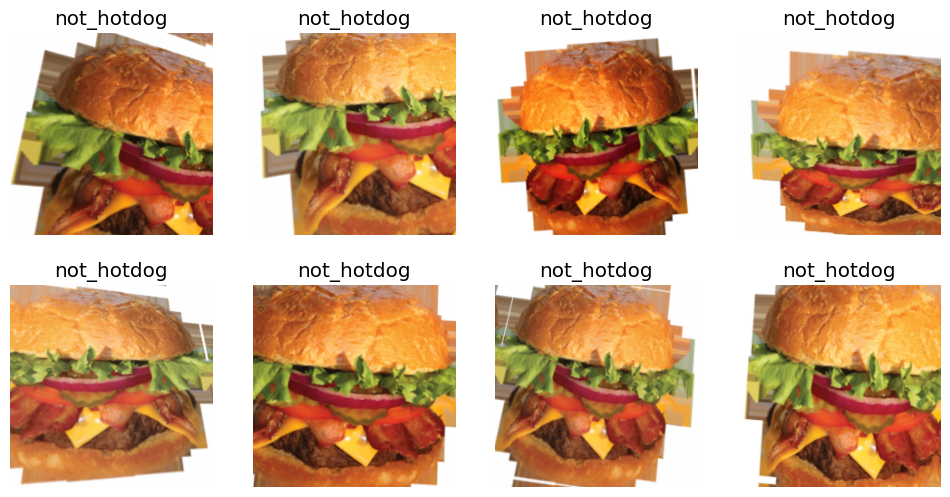

In [5]:
# Tell fastai where to get the data from and create the dataloaders
# Also shows how we transform the images RandomCropResize
dls = foods.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

# Train the model to clean the data

In [6]:
learn = fastbook.vision_learner(dls, fastbook.resnet18, metrics=fastbook.error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.659597,1.690837,0.558559,00:05


epoch,train_loss,valid_loss,error_rate,time
0,1.038028,0.774030,0.288288,00:05
1,0.764489,0.320640,0.099099,00:05
2,0.587907,0.200283,0.063063,00:05
3,0.478691,0.147551,0.045045,00:05


In [7]:
learn.dls.vocab

['hotdogs', 'not_hotdog']

Create the confusion matrix from the training and validation.

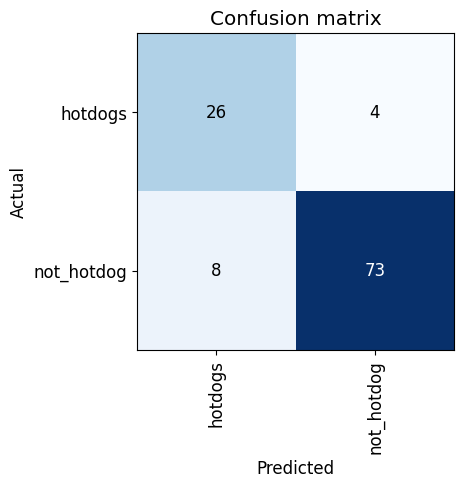

In [8]:
interp = fastbook.ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Let's see the images with the highest `loss`.

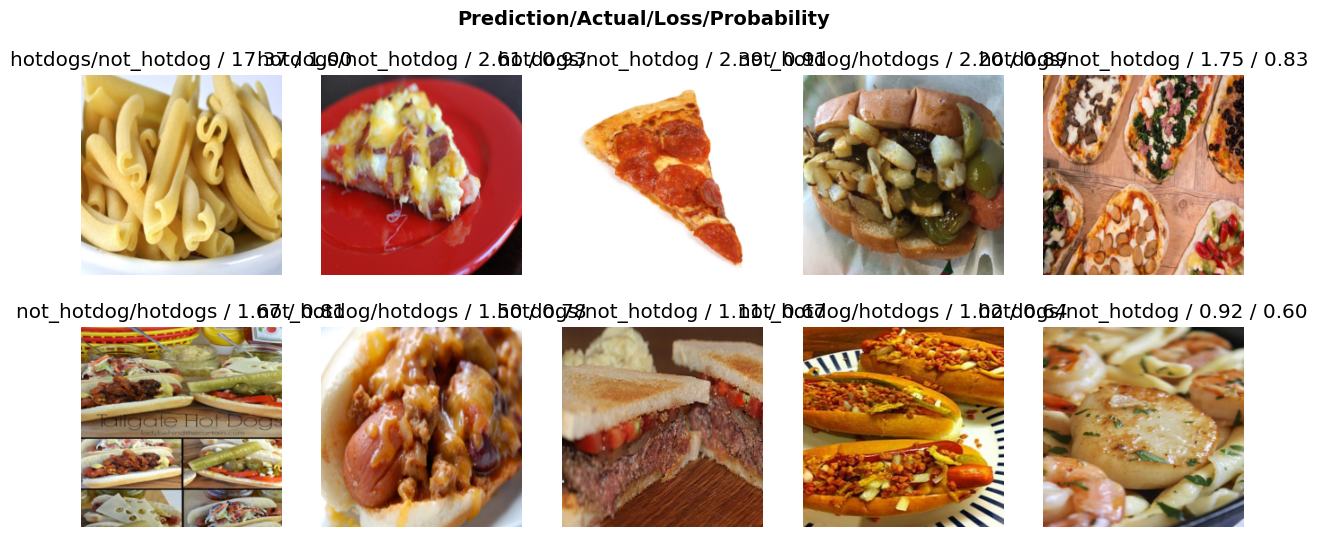

In [14]:
interp.plot_top_losses(10, nrows=2)

The model helped us detect problematic images.

Let's do some data cleaning using the `ImageClassifierCleaner()` from `fastai`.

In [49]:
from fastai.vision.widgets import *

In [16]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [17]:
# Let's delete the selected images
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

# Re-train the model

In [20]:
# Retrain the model
dls = foods.dataloaders(path)
learn = fastbook.vision_learner(dls, fastbook.resnet18, metrics=fastbook.error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.199582,1.908762,0.621622,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.621607,0.878419,0.351351,00:05
1,0.499146,0.740426,0.207207,00:05
2,0.405215,0.610323,0.153153,00:05
3,0.336463,0.473719,0.126126,00:05


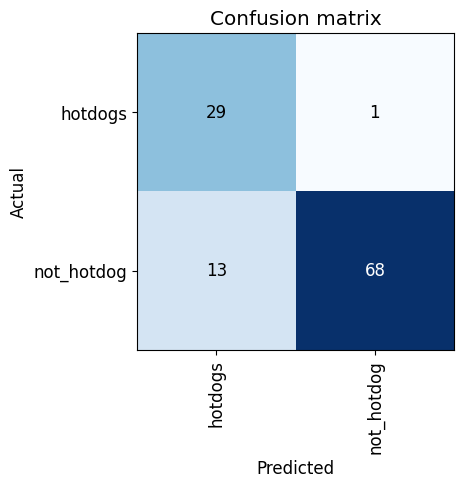

In [21]:
interp = fastbook.ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

---

# Test the model

In [28]:
!mkdir images/test

In [43]:
!wget https://www.lawson-philippines.com/wp-content/uploads/2022/11/Classic-Hotdog-min.jpg -O images/test/hotdog.jpg
!wget https://www.acouplecooks.com/wp-content/uploads/2022/09/Cheesecake-Ice-Cream-006.jpg -O images/test/icecream.jpg

--2024-02-10 15:10:36--  https://www.lawson-philippines.com/wp-content/uploads/2022/11/Classic-Hotdog-min.jpg
Resolving www.lawson-philippines.com (www.lawson-philippines.com)... 43.224.34.243
Connecting to www.lawson-philippines.com (www.lawson-philippines.com)|43.224.34.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 895832 (875K) [image/jpeg]
Saving to: ‘images/test/hotdog.jpg’

images/test/hotdog. 100%[===================>] 874.84K   561KB/s    in 1.6s    

2024-02-10 15:10:39 (561 KB/s) - ‘images/test/hotdog.jpg’ saved [895832/895832]

--2024-02-10 15:10:39--  https://www.acouplecooks.com/wp-content/uploads/2022/09/Cheesecake-Ice-Cream-006.jpg
Resolving www.acouplecooks.com (www.acouplecooks.com)... 104.18.7.55, 104.18.6.55, 2606:4700::6812:737, ...
Connecting to www.acouplecooks.com (www.acouplecooks.com)|104.18.7.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94690 (92K) [image/jpeg]
Saving to: ‘images/test/icecream.jpg

In [44]:
!ls images/test

hotdog.jpg  icecream.jpg


In [42]:
learn.predict("images/test/hotdog.jpg")

('hotdogs', tensor(0), tensor([1.0000e+00, 1.2571e-08]))

In [45]:
learn.predict("images/test/icecream.jpg")

('not_hotdog', tensor(1), tensor([0.0865, 0.9135]))

THe inference returns the `prediction`, `category index` and the `and the probabilities` of each category.

In [51]:
# The vocab matches the index
pred, cat_index, probs = learn.predict("images/test/hotdog.jpg")

---

# Create the app

In [79]:
from ipywidgets import *

In [80]:
btn_upload = widgets.FileUpload()
btn_run = widgets.Button(description='Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [99]:
def on_click_classify(change):
    img = fastbook.PILImage.create(btn_upload.value[0].content.tobytes())
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(224,224))
    pred,pred_idx,probs = learn.predict(img)
    lbl_pred.value = f"Prediction: {pred}; Probability: {probs[pred_idx]:.04f}"

btn_run.on_click(on_click_classify)

In [100]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])